# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Benjamin Chooyin, Estelle McCool, Brad Wang, Alyssa Heggison (Group 26) 

## General Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn

In [2]:
# Load data
data = pd.read_csv("the_office.csv")
data = pd.DataFrame(data)

data_kaggle = pd.read_csv('datasets/the_office_kaggle.csv')
data_kaggle = pd.DataFrame(data_kaggle)

data_scripts = pd.read_csv('datasets/the_office_lines_scripts.csv')
data_scripts = pd.DataFrame(data_scripts)

Datasets that could be used to count dialogue

https://data.world/abhinavr8/the-office-scripts-dataset/workspace/file?filename=the-office-lines+-+scripts.csv

https://www.kaggle.com/datasets/chazzer/the-office-quotes-dataset?select=talking_head.csv

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

We do an exploratory data analysis to get a sense of the variables

First we take an elementary look at some random rows of it as well as check the data types of the columns and the existence of missing values in data.

In [3]:
data.sample(5)

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
57,4,11,Survivor Man,Paul Feig,Steve Carell,8.3,2110,2007-11-08,233,64,2718,15,Andy;Angela;Creed;Dwight;Jim;Kelly;Kevin;Mered...
62,4,16,Did I Stutter?,Randall Einhorn,Brent Forrester;Justin Spitzer,8.4,2087,2008-05-01,255,26,2816,15,Andy;Angela;Creed;Darryl;Dwight;Jim;Kelly;Kevi...
8,2,3,Office Olympics,Paul Feig,Michael Schur,8.4,2742,2005-10-04,281,33,2604,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
165,9,3,Andy's Ancestry,David Rogers,Jonathan Green;Gabe Miller,7.5,1461,2012-10-04,243,48,2707,17,Andy;Angela;Darryl;Dwight;Erin;Jim;Kevin;Mered...
109,6,21,Happy Hour,Matt Sohn,B.J. Novak,8.6,1873,2010-03-25,359,45,2766,24,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


A few observations could be made.

1. The data contains numerical values and strings, where the latter needs to be encoded to be utilised by the model.
2. The columns $\texttt{season}$, $\texttt{episode}$ and $\texttt{total\_votes}$ are not controllable in terms of film producing, and so should not be considered as inputs of the final model. However, we could still test their correlations with the rating. 
3. The column $\texttt{air\_date}$ needs to be transformed (e.g. into the number of days from the eariliest airdate) to be used as a numerical variable. 
4. The strings of the columns $\texttt{writers}$ and $\texttt{main\_chars}$ are writer/character names separated by $\textbf{;}$, and we would split them and then encode the apprearance of each individual writer/character. 
5. The name of a episode might have effects on the number of people who decide to watch it, and thereby the number of votes it gets. However, considering we have a relatively small dataset (186 observations), the analysis of the effects of episode names (Further research: natural language processing and semantic analysis)
6. There are no missing values in the data.

We further take a look at the scaling and distributing features of the data.

In [5]:
data.describe()

,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,5.462366,12.478495,8.250538,2129.543011,296.397849,50.150538,3053.510753,20.693548
std,2.398464,7.233710,0.535168,790.787586,81.998568,23.941797,799.271717,5.092407
min,1.000000,1.000000,6.700000,1393.000000,131.000000,11.000000,1098.000000,12.000000
25%,3.000000,6.000000,7.900000,1628.500000,255.250000,34.000000,2670.250000,17.000000
50%,6.000000,12.000000,8.200000,1954.000000,281.000000,46.000000,2872.500000,20.000000
75%,7.750000,18.000000,8.600000,2385.000000,314.500000,60.000000,3141.000000,23.000000
max,9.000000,28.000000,9.700000,7934.000000,625.000000,166.000000,6076.000000,54.000000


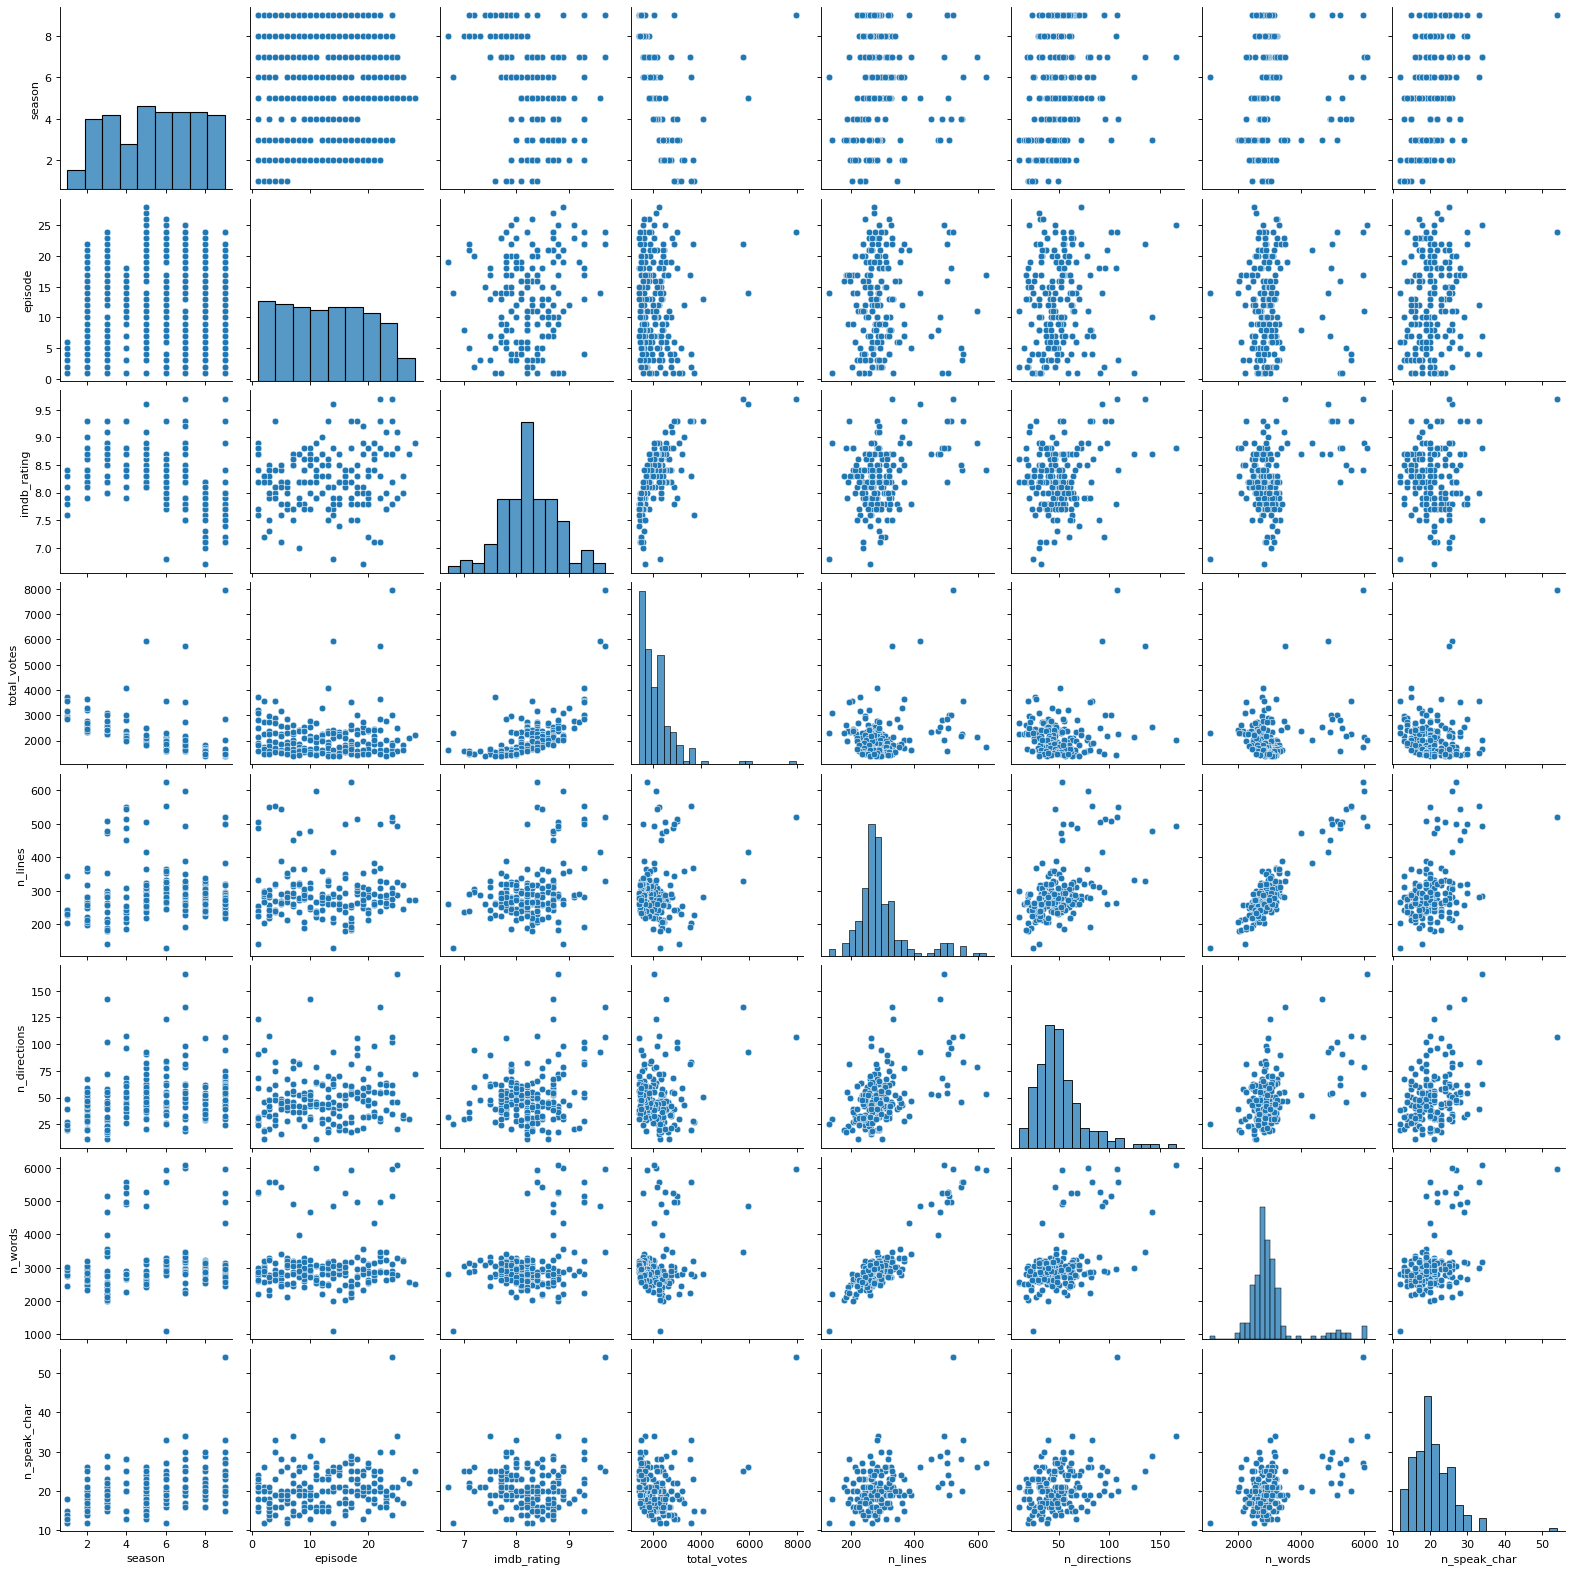

In [6]:
# The data contains 186 episodes with a mean ammount of votes 2130 per episode and a mean rating of 8.25. 
sns.pairplot(data)

The described statictics show that numerical variables are of quite different scales, which implies normalisation might need to be performed. Many of these pairplots contain little information but there are some interesting trends. 

1. Season 8 was particularly unpopular.
2. The ratings are normally distributed.
3. The number of lines and number of words are strongly correlated so we may not need both variables. 
4. There seems to be some quadratic correlation between the total votes and the imbd rating.

In [35]:
'''
   Data Formatting
'''
data_numeric = data.copy()
pd.options.mode.chained_assignment = None 


'''
   Construct lists for string columns
'''
#split character column by columns instead of semicolons
for i in range(0,len(data.main_chars)):
   data_numeric.main_chars[i] = data.main_chars[i].split(';')
#same for writer column
for i in range(0,len(data.writer)):
   data_numeric.writer[i] = data.writer[i].split(';')
#Director
for i in range(0,len(data.director)):
   data_numeric.director[i] = data.director[i].split(';')

#turn season data into a string for future use
data_numeric.season = data_numeric.season.astype(str)


'''
   One hot encoding all of the categorical columns
'''
#Import function for multi variable one hot encoder 
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

#Directors
encoded_directors = pd.DataFrame(mlb.fit_transform(data_numeric['director']), columns= mlb.classes_)

#Writer
encoded_writers = pd.DataFrame(mlb.fit_transform(data_numeric['writer']), columns= mlb.classes_)

#Seasons as although they are an integer we dont want them to behave like an integer
encoded_seasons = pd.DataFrame(mlb.fit_transform(data_numeric['season']), columns= mlb.classes_)

#One hot encoding the main characters
encoded_characters = pd.DataFrame(mlb.fit_transform(data_numeric["main_chars"]), columns= mlb.classes_)

#Removing all duplicate typos of Names
pd.set_option('display.max_rows', None)
def remove_typos(data, correct, typo):
    removed = np.zeros(shape = (186))
    data[correct] = encoded_directors[correct] + data[typo]
    data[typo] = removed
    return data.drop(typo, axis = 1)

encoded_directors = remove_typos(encoded_directors,'Greg Daniels', 'Greg Daneils')
encoded_directors = remove_typos(encoded_directors,'Charles McDougal', 'Charles McDougall')

# Add suffix
encoded_directors = encoded_directors.add_suffix(' dir')
encoded_writers = encoded_writers.add_suffix(' wri')
encoded_characters = encoded_characters.add_suffix(' char')


'''
   Merge the less frequent directors/writers
'''
# Filter out those directors
other_directors = encoded_directors.columns[encoded_directors.sum() < 5]

# Sum to a new column 'Other directors'
encoded_directors['Other directors'] = encoded_directors[other_directors].sum(axis=1)

# Drop those directors
encoded_directors = encoded_directors.drop(other_directors, axis=1)

# Filter out those writers
other_writers = encoded_writers.columns[encoded_writers.sum() < 5]

# Sum to a new column 'Other writers'
encoded_writers['Other writers'] = encoded_writers[other_writers].sum(axis=1)

# Drop those writers
encoded_writers = encoded_writers.drop(other_writers, axis=1)


'''
   Joining the One hot encoded columns with the original data frame
'''
data_numeric = data_numeric.join([encoded_characters])
data_numeric = data_numeric.drop(['director', 'main_chars', 'writer'], axis=1)

data_numeric = data_numeric.join(encoded_writers)
data_numeric = data_numeric.join(encoded_directors)


'''
   Construct season variables and time-period in year from the earliest air_date
'''
seasons = {'spring': (3, 4, 5), 
           'summer': (6, 7, 8),
           'autumn': (9, 10, 11),
           'winter': (12, 1, 2)}
for season in seasons:
   data_numeric[season] = 0
   for i in range(len(data_numeric)):
      data_numeric[season][i] = int(int(data_numeric['air_date'][i].split('-')[1]) in seasons[season])

for i in range(len(data_numeric)):   
   data_numeric['air_year'] = int(data_numeric['air_date'][i].split('-')[0])
data_numeric['air_year'] = data_numeric['air_year'] - data_numeric['air_year'].min()


'''
   Create the only id 'season_episode' for later extra data merge
   and remove repeated columns
'''
data_numeric['season_episode'] = 's' + data_numeric['season'].astype(str) + '_e' + data_numeric['episode'].astype(str)
data_numeric = data_numeric.drop(['season', 'episode', 'air_date'], axis=1)


pd.set_option('display.max_columns', None)
data_numeric.head()

,episode_name,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,Andy char,Angela char,Creed char,Darryl char,Dwight char,Erin char,Jim char,Kelly char,Kevin char,Meredith char,Michael char,Oscar char,Pam char,Phyllis char,Ryan char,Stanley char,Toby char,Aaron Shure wri,B.J. Novak wri,Brent Forrester wri,Charlie Grandy wri,Daniel Chun wri,Gene Stupnitsky wri,Greg Daniels wri,Halsted Sullivan wri,Jennifer Celotta wri,Justin Spitzer wri,Lee Eisenberg wri,Michael Schur wri,Mindy Kaling wri,Paul Lieberstein wri,Warren Lieberstein wri,Other writers,B.J. Novak dir,Charles McDougal dir,David Rogers dir,Greg Daniels dir,Jeffrey Blitz dir,Ken Kwapis dir,Ken Whittingham dir,Matt Sohn dir,Paul Feig dir,Paul Lieberstein dir,Randall Einhorn dir,Other directors,spring,summer,autumn,winter,air_year,season_episode
0,Pilot,7.6,3706,229,27,2757,15,0,1,0,0,1,0,1,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,s1_e1
1,Diversity Day,8.3,3566,203,20,2808,12,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,s1_e2
2,Health Care,7.9,2983,244,21,2769,13,0,1,0,0,1,0,1,0,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,s1_e3
3,The Alliance,8.1,2886,243,24,2939,14,0,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,s1_e4
4,Basketball,8.4,3179,230,49,2437,18,0,1,0,1,1,0,1,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,s1_e5


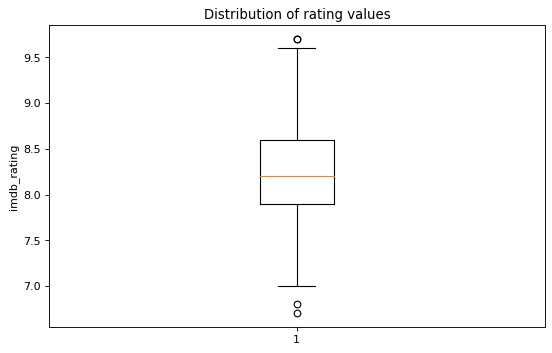

In [108]:
#Outlier removal 
#Plotting a box plot of ratings to view any outlier values 
fig2, ax2 = plt.subplots()
ax2.boxplot(data['imdb_rating'] )
ax2.set_ylabel("imdb_rating")
ax2.set_title("Distribution of rating values")

#We can see that there are a few outlier values
#We remove these below:
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Goodbye, Michael')], axis=0, inplace=True)
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Finale')], axis=0, inplace=True)
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Get The Girl')], axis=0, inplace=True)
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='The Banker')], axis=0, inplace=True)

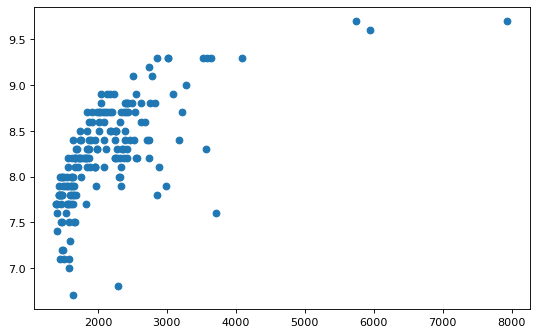

In [109]:
# Looking more closely at the total votes variable
# Correlation coeff of 0.65 with imdb_rating 

fig1, ax1 = plt.subplots()
ax1.scatter(data['total_votes'], data['imdb_rating'])

# There looks like a quadratic relationship
# We may not want to include total_votes as a predictor though, because it's not something 
# that the filming team can control. 

# But maybe we could argue for maximising total_votes as a response variable, rather than rating
# We will try this below 

In [8]:
data_scripts.head()


,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#I think we have a problem because the binary columns are being scaled.
# There are no zero or 1 values left in the directors columns  
#print(X_train)
# Actually all the values in X_train seem weird/ a lot of negatives - maybe we have made an error in the scaling? 

#Idea to fix this 
# Dropping all binary, text, date features frist
X = data_numeric.drop(['imdb_rating', 'episode_name', 'season_episode', 'total_votes'], axis = 1)
y = data_numeric['imdb_rating']

# Selecting and scaling only the real variables, not the encoded categorical variables 
X_real_only = data_numeric[['n_lines', 'n_directions', 'n_words', 'n_speak_char']]
X_bin_only = data_numeric.drop(['imdb_rating', 'episode_name', 'season_episode', 'total_votes', 'n_lines', 'n_directions', 'n_words', 'n_speak_char' ], axis = 1)
X_bin_array = X_bin_only.to_numpy()


#Scaling the real variables before joining the encoded columns back on
X_real_scaled = scaler.fit_transform(X_real_only)
X_scaled = np.concatenate((X_real_scaled, X_bin_array), axis = 1)

# Splitting into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 46 to 102
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   n_lines                 130 non-null    int64
 1   n_directions            130 non-null    int64
 2   n_words                 130 non-null    int64
 3   n_speak_char            130 non-null    int64
 4   Andy char               130 non-null    int64
 5   Angela char             130 non-null    int64
 6   Creed char              130 non-null    int64
 7   Darryl char             130 non-null    int64
 8   Dwight char             130 non-null    int64
 9   Erin char               130 non-null    int64
 10  Jim char                130 non-null    int64
 11  Kelly char              130 non-null    int64
 12  Kevin char              130 non-null    int64
 13  Meredith char           130 non-null    int64
 14  Michael char            130 non-null    int64
 15  Oscar char            

In [52]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [53]:

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

'''X = np.c_[X_train.bmi, 
          X_train.age,
          X_train.children,
          X_train.sex_female,
          X_train.smoker_yes
          ]'''

linreg = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
lm = linreg.fit(X_train, y_train)
beta = get_coefs(lm)
print(beta)

[ 8.27308320e+00  1.51872548e-01  3.33485146e-02  2.64572121e-02
  3.90587646e-02  1.21353922e-02 -6.33567783e-02  7.60135184e-04
 -3.83813965e-02 -4.41196928e+10 -7.37024238e-02  1.05712333e-01
  9.04529181e-02 -3.96314386e-02  6.64593779e-02  2.09442053e-01
 -8.65308718e-02 -4.71222867e-02 -6.13759543e-02 -9.70555312e-02
  3.27948244e-02  1.98527632e-02  1.52818873e-02  6.16663751e-02
  4.06426387e-02 -3.19741710e-02  2.03288182e-02 -8.16262846e+10
  9.86958338e-02  2.89787415e+10  9.11723340e-04  4.66130913e-02
  8.16262846e+10  3.24372717e-02  3.66749763e-02  1.02241516e-01
 -2.89787415e+10 -2.38418579e-03 -4.42352295e-02 -2.62069702e-02
 -1.95045471e-02  4.47959900e-02 -1.67665482e-02 -8.30421448e-02
 -3.23562622e-02 -3.75875831e-03 -3.54080200e-02 -9.54399109e-02
 -1.01303101e-01 -1.10946655e-01  5.08655397e+10  0.00000000e+00
  4.88422368e+10  4.44639466e+10  0.00000000e+00]


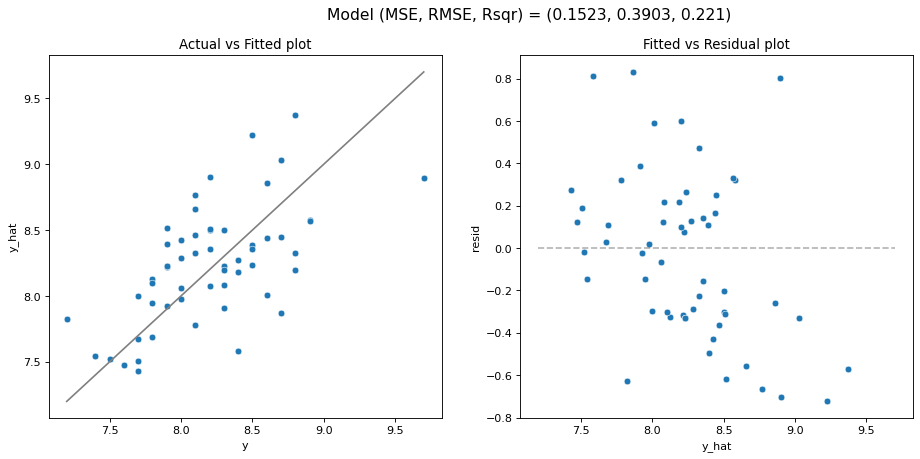

(0.15231738979674983, 0.39027860535359843, 0.22101251748624795)

In [88]:
model_fit(lm, X_test, y_test, plot = True)

In [102]:
def get_impt_features(pipeline, input_df, k):
    '''
        Get k most important features (positive or negative)
    '''
    coefs = get_coefs(pipeline)
    
    impt_idx = np.argsort(np.abs(coefs))[-k:]
    
    return pd.DataFrame({
        'Features': pipeline[:-1].get_feature_names_out(input_df.columns)[impt_idx],
        'Coefficients': coefs[impt_idx]
    })
    

In [103]:
get_impt_features(lm, X_train, 15)

,Features,Coefficients
0,Other directors,-1.013031e-01
1,Warren Lieberstein wri,1.022415e-01
2,Kelly char,1.057123e-01
3,spring,-1.109467e-01
4,n_directions,1.518725e-01
5,Oscar char,2.094421e-01
6,n_lines,8.273083e+00
7,Other writers,-2.897874e+10
8,Jennifer Celotta wri,2.897874e+10
9,Erin char,-4.411969e+10


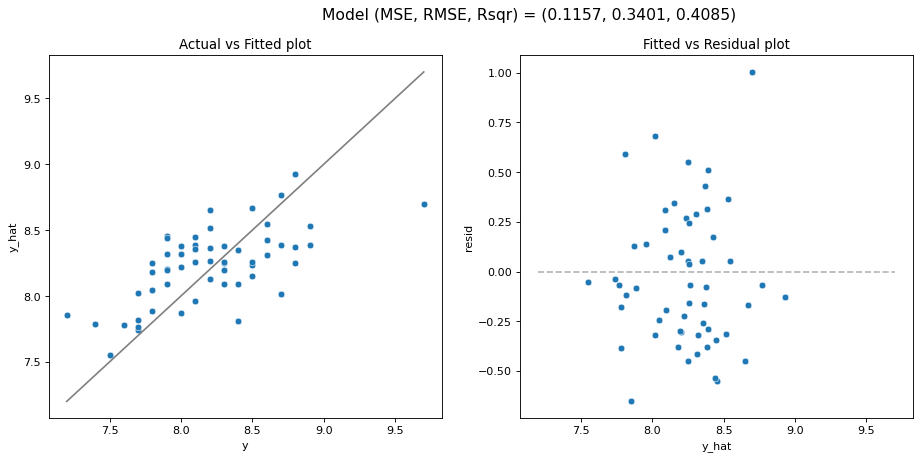

(0.11565753879628603, 0.3400846053503246, 0.40849974450797777)

In [104]:
# First attempt at Ridge Regression 
from sklearn.linear_model import Ridge

#Setting alpha value
a = 100

#Fitting the ridge regression model to the training set
ridge_scaled = make_pipeline(
    StandardScaler(),
    Ridge(alpha = a)
).fit(X_train, y_train)

#Testing the ridge regression model on the testing set
model_fit(ridge_scaled, X_test, y_test, plot = True)


In [105]:
get_impt_features(ridge_scaled, X_train, 15)

,Features,Coefficients
0,Dwight char,-0.026934
1,Daniel Chun wri,-0.029804
2,Pam char,-0.030955
3,n_words,0.034436
4,Halsted Sullivan wri,0.035301
5,Jeffrey Blitz dir,0.041044
6,Warren Lieberstein wri,0.041376
7,B.J. Novak dir,-0.043819
8,Kevin char,0.044583
9,Kelly char,0.056802


In [60]:
#Parameter tuning using method from WS5

alphas = np.linspace(0, 60, num=200)

gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs.fit(X_train, y_train)
print(gs.best_params_)
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

#This gives a worse R^2 than above with a = 100, but I think a=38 is better because it's the one
#that was deemed the best when running 5-fold cross-valudation 

ValueError: 
All the 1000 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
800 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py", line 809, in fit
    return self.partial_fit(X, y, sample_weight)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py", line 844, in partial_fit
    X = self._validate_data(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 577, in _validate_data
    X = check_array(X, input_name="X", **check_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'Safety Training'

--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py", line 809, in fit
    return self.partial_fit(X, y, sample_weight)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py", line 844, in partial_fit
    X = self._validate_data(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 577, in _validate_data
    X = check_array(X, input_name="X", **check_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'Weight Loss (Parts 1&2)'


In [ ]:
#Removing the directors variables to see if this gives a better R^2



In [ ]:
#Trying out total votes as a dependent variable 
# This might not work out because rating has higher correlation with more variables

#Creating feature and response arrays  
tvX_scaled = np.delete(X_scaled, 1, 1) #object = 1, axis = 1
tv = X_scaled[:,1]

#Splitting into training and testing sets 
tvX_train, tvX_test, tvy_train, tvy_test = train_test_split(tvX_scaled, tv, test_size = 0.3, random_state = 42)

linreg = LinearRegression()
lmtv = linreg.fit(tvX_train, tvy_train)

model_fit(lmtv, tvX_test, tvy_test, plot = True)

#I think something is still wrong with the model but hopefully when we fix it above it'll carry through


In [112]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(
    PolynomialFeatures(degree = 3),
    LinearRegression()
)

print(poly_model)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])


In [113]:
poly_reg = poly_model.fit(X_train, y_train)

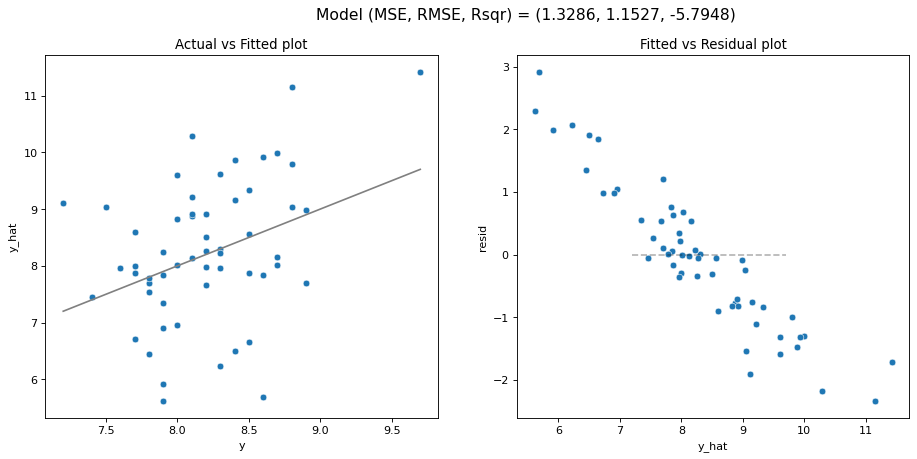

(1.3286079248337919, 1.152652560329344, -5.794818004662131)

In [114]:
model_fit(poly_reg, X_test, y_test, plot=True)

In [115]:
get_impt_features(poly_reg, X_train, 15)

,Features,Coefficients
0,n_directions n_words B.J. Novak dir,-0.000008
1,n_directions n_words Oscar char,-0.000008
2,n_words n_speak_char Gene Stupnitsky wri,0.000008
3,n_words n_speak_char Angela char,-0.000009
4,n_words n_speak_char Warren Lieberstein wri,-0.000009
5,n_directions n_words Creed char,-0.000009
6,n_directions n_words Michael char,0.000010
7,n_directions n_words Ken Kwapis dir,-0.000010
8,n_words n_speak_char Ryan char,-0.000010
9,n_directions n_words Other directors,0.000011


In [ ]:
print(poly_reg.steps[1][1].intercept_) # second subset is necessary here because 
                                       # each step is a tuple of a name and the 
                                       # model / transform o
                                       
                                       
model_fit(poly_reg, X_test, y_test, plot=True)


In [116]:
a = 0.1

poly_ridge = make_pipeline(
    PolynomialFeatures(degree = 2),
    StandardScaler(),
    Ridge(alpha = a)
)

poly_ridge.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.1))])

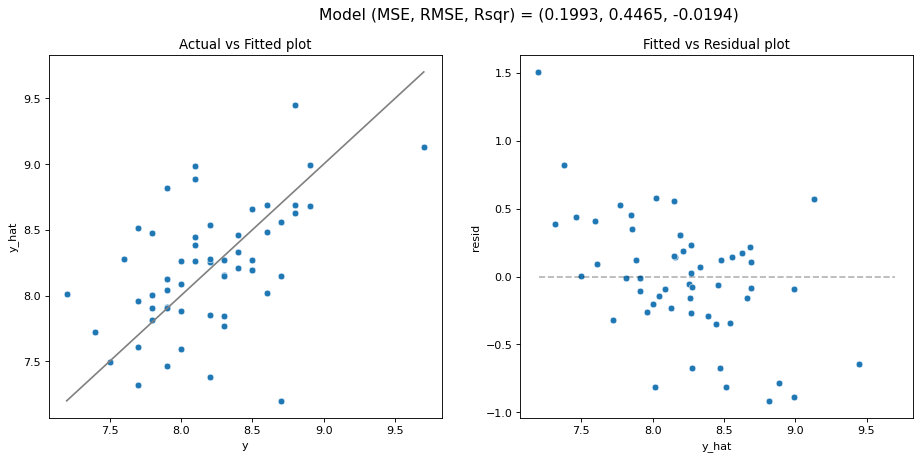

(0.19932215843340298, 0.44645510237133923, -0.019381087178773182)

In [117]:
model_fit(poly_ridge, X_test, y_test, plot=True)

In [119]:
get_impt_features(poly_ridge, X_train, 30)

,Features,Coefficients
0,Darryl char Daniel Chun wri,-0.039128
1,Justin Spitzer wri winter,0.039371
2,n_directions Darryl char,0.040553
3,Creed char Daniel Chun wri,-0.040765
4,Meredith char Daniel Chun wri,-0.040765
5,Oscar char Daniel Chun wri,-0.040765
6,Toby char Daniel Chun wri,-0.040918
7,Phyllis char Brent Forrester wri,-0.041092
8,Darryl char Stanley char,-0.041157
9,Meredith char B.J. Novak dir,0.041472


In [ ]:
alphas = np.linspace(0, 60, num=200)

gs = GridSearchCV(
    make_pipeline(
        PolynomialFeatures(degree = 2),
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_mean_squared_error"
)

gs.fit(X_train, y_train)
print(gs.best_params_)
model_fit(gs.best_estimator_, X_test, y_test, plot=True)


In [ ]:
poly_ridge_coefs = get_coefs(poly_ridge)

quadratic is good, cubic is worse. could do a plot of degree against an accuracy metric or cross validation to show that quadratic is the right choice.

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from